In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,)
# sklearnの仕様変更にともない変更
# source: https://github.com/YutaroOgawa/Deep-Reinforcement-Learning-Book/issues/4

# MNISTデータの前処理

In [2]:
# 28x28ピクセルごとの0-255の数値を0-1に変換
X = mnist.data / 255  
# 正解ラベルを取得
y = mnist.target.astype('u1')
# 同じく上記仕様変更にともないオリジナルはstrのため型変換も追加で行う

この画像データのラベルは5です


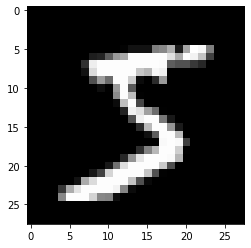

In [3]:
%matplotlib inline
# MNISTのデータの1つ目をmatplotlib.pyplotで描画する
import matplotlib.pyplot as plt

plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{:.0f}です".format(y[0]))
# y[0]の型が最初からstrだったため直に出力

# DataLoderの作成

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# データを訓練とテストのために、6:1に分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=0)

# データをPyTorchのTensorに変換
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# データとラベルをセットにしたDatasetを作成
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# データセットのミニバッチサイズを指定した、Dataloaderを作成

In [5]:
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)
# loader_test用のbatch_sizeが抜けていたためtrainと同じ値を記入

# ネットワークの構築

In [6]:
# Keras風の書き方 Define and Run

from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


# ニューラルネットワークの設定（Chainer風の書き方）上と同等

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)  # Chainerと異なり、Noneは受けつけない。
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)
    def forward(self, x):
        # 入力xに合わせてforwardの計算を変えられる＝Define by Run
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

model = Net(n_in=28*28, n_mid=100, n_out=10)  # ネットワークのオブジェクトを生成
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


# 誤差関数と最適化手法の設定

In [8]:
from torch import optim

# 誤差関数の設定
loss_fn = nn.CrossEntropyLoss()  # 変数名にはcriterionも使われる

# 重みを学習する際の最適化手法の選択
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 5. 学習と推論の設定

In [9]:
# 学習1回でやることを定義します
# Chainerのtraining.Trainer()に対応するものはない

from torch.autograd import Variable

In [10]:
def train(epoch):
    model.train()  # ネットワークを学習モードに切り替える

    # データローダーから1ミニバッチずつ取り出して計算する
    for data, target in loader_train:
        data, target = Variable(data), Variable(target)  # 微分可能に変換
        optimizer.zero_grad()  # 一度計算された勾配結果を0にリセット

        output = model(data)  # 入力dataをinputし、出力を求める
        loss = loss_fn(output, target)  # 出力と訓練データの正解との誤差を求める
        loss.backward()  # 誤差のバックプロパゲーションを求める
        optimizer.step()  # バックプロパゲーションの値で重みを更新する

    print("epoch{}：終了\n".format(epoch))

# Chainerのtrainer.extend(extensions.Evaluator())に対応するものはない

In [11]:
def test():
    model.eval()  # ネットワークを推論モードに切り替える
    correct = 0
 
    # データローダーから1ミニバッチずつ取り出して計算する
    for data, target in loader_test:
        data, target = Variable(data), Variable(target)  # 微分可能に変換
        output = model(data)  # 入力dataをinputし、出力を求める
 
        # 推論する
        pred = output.data.max(1, keepdim=True)[1]  # 出力ラベルを求める
        correct += pred.eq(target.data.view_as(pred)).sum()  # 正解と一緒だったらカウントアップ
 
    # 正解率を出力
    data_num = len(loader_test.dataset)  # データの総数
    print('\nテストデータの正解率: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))

# 学習なしにテストデータで推論してみよう

In [12]:
test()


テストデータの正解率: 888/10000 (8%)



# 60000のデータに3エポック学習を実行する

In [13]:
for epoch in range(3):
    train(epoch)
test()

epoch0：終了

epoch1：終了

epoch2：終了


テストデータの正解率: 9556/10000 (95%)

